In [1]:
from utils_v1 import *


In [2]:
from icecream import ic
import pdb
from sklearn import metrics
import importlib
import utils_v1
import pathlib
import cv2
import sys
import numpy as np
from src import metrics as _metrics
from src.dataset import Para, ParaDeforestationTime, ParaDistanceMap, ParaMultipleDates
from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates


In [3]:
# dataset = ParaDeforestationTime()
addPastDeforestationInput = True
dataset = ParaMultipleDates(dates = [2018, 2019], # dates = [2017, 2018, 2019]. [2018, 2019]. [2015, 2016, 2017, 2018]
	addPastDeforestationInput = addPastDeforestationInput,
	borderBuffer = 2)
# [2016, 2017, 2018]
# dataset = Para()
if type(dataset) != ParaMultipleDates:
	patchesHandler = PatchesHandler()
else:
	patchesHandler = PatchesHandlerMultipleDates(
		dataset)

training = True
save_probabilities = False
loadInference = False
if training == False:
	if type(dataset) == Para:
		exp = 2

	if type(dataset) == ParaDeforestationTime:
		# exp = 3 # uses past deforestation mask until 2020, which is a mistake. use it until 2018
		exp = 4 # uses past deforestation mask without dates.
		exp = 5 # uses past deforestation mask with dates. 38 epochs.
		exp = 5 # fixes mask.
		exp = 6 # uses past deforestation distance and past deforestation. didnt test it yet        
		exp = 8 # Uses fixed past deforestation distance and past deforestation. 98.9 mAP
		exp = 9 # dummy for coords. high mAP. 99.8.   
		exp = 10 # using fixed fixed past deforestation distance. mAP 90.7   
		exp = 12 # Multiple dates. using fixed fixed past deforestation distance. mAP reduced to 89.6
	if type(dataset) == ParaDistanceMap:
		exp = 7 # not so good result.
	if type(dataset) == ParaMultipleDates:
		exp = 11 # Multiple dates. using fixed fixed past deforestation distance
		exp = 22
		exp = 50
		exp = 52
		# exp = 54
		exp = 56
		exp = 58

else:
	exp = 13 # Multiple dates. using fixed fixed past deforestation distance
	exp = 61

ic| list(self.date_ids): [0]
ic| self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]
ic| self.input_image_shape: 21
ic| self.dataset.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]


In [4]:
figures_path = 'figures' + dataset.__class__.__name__ + '/'
pathlib.Path(figures_path).mkdir(parents=True, exist_ok=True)
title_name = 'ResUnet'

In [5]:
# ic(type(dataset), exp, dataset.dates)


In [6]:
# Loading reference
label_mask = dataset.loadLabel()
print('Mask label shape: ', '\n', label_mask.shape, '\n', 'Unique values: ', '\n', np.unique(label_mask))

D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0., 2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015.,
                                                                    2016., 2017., 2018., 2019., 2020., 2021.], dtype=float32),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299508,
                                                                      2477969,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2018) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0., 2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015.,
                                                                    2016., 2017., 2018., 2019., 2020., 2021.], dtype=float32),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299508,
                                                                      2477969,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0., 2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015.,
                                                                    2016., 2017., 2018., 2019., 2020., 2021.], dtype=float32),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299508,
                                                                      2477969,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([0., 1.], dtype=float32), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0., 2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015.,
                                                                    2016., 2017., 2018., 2019., 2020., 2021.], dtype=float32),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299508,
                                                                      2477969,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


Mask label shape:  
 (17730, 9203, 1) 
 Unique values:  
 [0 1 2]


In [7]:
np.save('label_not_independent.npy', label_mask)


In [8]:
# Creating tile mask

mask_tiles = create_mask(label_mask.shape[0], label_mask.shape[1], 
        grid_size=(dataset.grid_x, dataset.grid_y))
label_mask = label_mask[:mask_tiles.shape[0], :mask_tiles.shape[1]]

Tiles size:  3546 2300
Mask size:  (17730, 9200)


In [9]:
label_mask.dtype

dtype('uint8')

In [10]:
label_mask_current_deforestation = dataset.getLabelCurrentDeforestation(
        label_mask)

In [11]:
label_mask.dtype

dtype('uint8')

In [12]:
# Loading image stack
image_stack = dataset.loadInputImage()

print('Image shape: ', image_stack.shape)
channels = image_stack.shape[-1]
image_stack = image_stack[:mask_tiles.shape[0], :mask_tiles.shape[1],:]
print('mask: ',mask_tiles.shape)
print('image stack: ', image_stack.shape)
print('ref :', label_mask.shape)
#plt.imshow(mask_tiles)

ic| image_stack.shape: (17730, 9203, 21)


Image shape:  (17730, 9203, 21)
mask:  (17730, 9200)
image stack:  (17730, 9200, 21)
ref : (17730, 9200, 1)


In [13]:
ic(image_stack.shape)
channels = image_stack.shape[-1]
ic(channels)

ic| image_stack.shape: (17730, 9200, 21)
ic| channels: 21


21

In [14]:
mask_tr_val, mask_amazon_ts = dataset.getTrainValTestMasks(mask_tiles)


Training tiles:  [1, 3, 5, 8, 11, 13, 14, 20]
Validation tiles:  [6, 19]
Test tiles:  [2, 4, 7, 9, 10, 12, 15, 16, 17, 18]


In [15]:

patch_size = 128
if training == True:

    # Extracting patches from the idx matrix
    overlap = 0.7
    batch_size = 32
    im_idx = patchesHandler.create_idx_image(label_mask)


ic| im_idx_row.shape: (17730, 9200, 1)
    im_idx_col.shape: (17730, 9200, 1)
ic| im_idx_row.dtype: dtype('uint16')
    im_idx_col.dtype: dtype('uint16')
ic| im_idx.shape: (17730, 9200, 2), im_idx.dtype: dtype('uint16')


In [16]:
import importlib
if training == True:
	coords = patchesHandler.extract_patches(
		im_idx, patch_size=(patch_size, patch_size, 2), 
		overlap=overlap)

	coords_train, coords_val = patchesHandler.trainTestSplit(coords,
		mask_tr_val, patch_size=(patch_size, patch_size, 2))

	ic(coords_train.shape, coords_val.shape)
	# del im_idx

ic| coords.shape: (464, 239, 1, 128, 128, 2)
    coords.dtype: dtype('uint16')
ic| coords.shape: (110896, 2), coords.dtype: dtype('uint16')
ic| coords_train.shape: (41812, 3), coords_val.shape: (10260, 3)


In [17]:
label_mask.shape

(17730, 9200, 1)

(-0.5, 9199.5, 17729.5, -0.5)

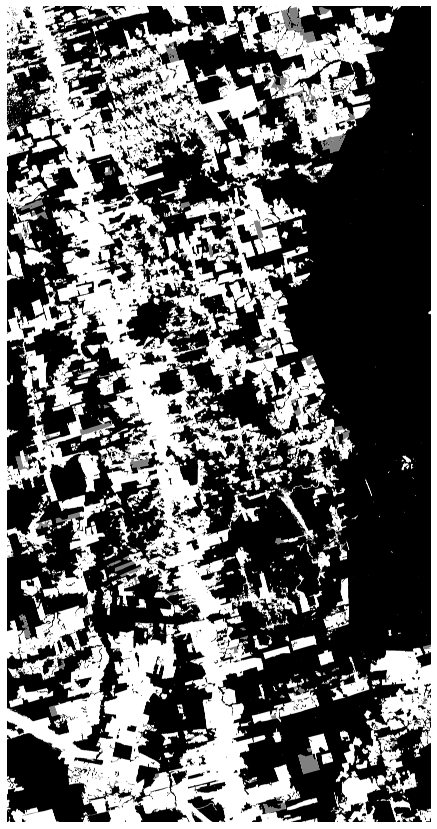

In [18]:

plt.figure(figsize=(15,15))
if type(dataset) != ParaDeforestationTime:
    plt.imshow(label_mask[...,-1], cmap=plt.cm.gray)
else:
    plt.imshow(label_mask, cmap=plt.cm.gray)

# title_name = 'ResUnet'
plt.axis('off')
# plt.savefig('figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [19]:
if training == True:
    print(coords_train)

[[    0     0     0]
 [    0    38     0]
 [    0    76     0]
 ...
 [17594  8968     0]
 [17594  9006     0]
 [17594  9044     0]]


In [20]:
if training == True:

    # Keeping patches with 2% of def class
    coords_train = patchesHandler.retrieve_idx_percentage(label_mask, coords_train, 
			patch_size, pertentage = 0.2)
    coords_val = patchesHandler.retrieve_idx_percentage(label_mask, coords_val, 
			patch_size, pertentage = 0.2)
    print('training samples: ', coords_train.shape, 
			'validation samples: ', coords_val.shape)


training samples:  (3753, 3) validation samples:  (1032, 3)


In [21]:
# Creating train and validation data generator
# importlib.reload(patchesHandler)
import pdb
if training == True:

	train_datagen = ImageDataGenerator()
	valid_datagen = ImageDataGenerator()
	# pdb.set_trace()
	len_X_train = coords_train.shape[0]
	len_X_valid = coords_val.shape[0]

	train_gen = train_datagen.flow(
			np.expand_dims(np.expand_dims(coords_train, axis = -1), axis = -1), 
			np.expand_dims(np.expand_dims(coords_train, axis = -1), axis = -1),
			batch_size=batch_size,
			shuffle=True)
	# pdb.set_trace()

	valid_gen = valid_datagen.flow(
			np.expand_dims(np.expand_dims(coords_val, axis = -1), axis = -1), 
			np.expand_dims(np.expand_dims(coords_val, axis = -1), axis = -1),
			batch_size=batch_size,
			shuffle=False)

	number_class = 3
	train_gen_batch = patchesHandler.batch_generator(train_gen,
			image_stack, label_mask, patch_size, number_class)
	valid_gen_batch = patchesHandler.batch_generator(valid_gen,
			image_stack, label_mask, patch_size, number_class)

	#del image_stack

In [22]:
# Creating folder for the experiment

path_exp = dataset.paths.experiment + 'exp' + str(exp)
path_models = path_exp+'/models'
path_maps = path_exp+'/pred_maps'

if not os.path.exists(path_exp):
    os.makedirs(path_exp)   
if not os.path.exists(path_models):
    os.makedirs(path_models)   
if not os.path.exists(path_maps):
    os.makedirs(path_maps)
    
times = 1
method = 'resunet'
nb_filters = [16, 32, 64, 128, 256]
weights = [0.1, 0.9, 0]

In [23]:
if type(patchesHandler) == PatchesHandlerMultipleDates:
	channels = patchesHandler.input_image_shape

In [24]:
path_exp

'D:/Jorge/datasets/deforestation/experiments/exp60'

In [25]:
channels

21

In [26]:
image_stack.shape

(17730, 9200, 21)

In [27]:

metrics_all = []
if training == True:
    for tm in range(0,times):
        print('time: ', tm)

        rows = patch_size
        cols = patch_size
        adam = Adam(lr = 1e-3 , beta_1=0.9)
        
        loss = weighted_categorical_crossentropy(weights)
        input_shape = (rows, cols, channels)
        model = build_resunet_dropout_spatial(input_shape, nb_filters, number_class)
        
        model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])
        model.summary()

        earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min')
        checkpoint = ModelCheckpoint(path_models+ '/' + method +'_'+str(tm)+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        lr_reduce = ReduceLROnPlateau(factor=0.9, min_delta=0.0001, patience=5, verbose=1)
        callbacks_list = [earlystop, checkpoint]
        # train the model
        start_training = time.time()
        history = model.fit_generator(train_gen_batch,
                                steps_per_epoch=len_X_train*3//train_gen.batch_size,
                                validation_data=valid_gen_batch,
                                validation_steps=len_X_valid*3//valid_gen.batch_size,
                                epochs=100,
                                callbacks=callbacks_list)
        end_training = time.time() - start_training
        # metrics_all.append(end_training)
        del model, history

    # Saving training time
    # np.save(path_exp+'/metrics_tr.npy', metrics_all)
    del train_gen_batch, valid_gen_batch

time:  0


c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_enc_net (InputLayer)      [(None, 128, 128, 21 0                                            
__________________________________________________________________________________________________
res1_net1 (Conv2D)              (None, 128, 128, 16) 3040        input_enc_net[0][0]              
__________________________________________________________________________________________________
drop_net1 (SpatialDropout2D)    (None, 128, 128, 16) 0           res1_net1[0][0]                  
__________________________________________________________________________________________________
res2_net1 (Conv2D)              (None, 128, 128, 16) 2320        drop_net1[0][0]                  
______________________________________________________________________________________________

c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\engine\training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


351/351 [==============================] - 37s 92ms/step - loss: 0.0704 - accuracy: 0.8531 - val_loss: 0.0489 - val_accuracy: 0.9085

Epoch 00001: val_loss improved from inf to 0.04885, saving model to D:/Jorge/datasets/deforestation/experiments/exp60/models\resunet_0.h5
Epoch 2/100
  2/351 [..............................] - ETA: 23s - loss: 0.0534 - accuracy: 0.9081

c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


351/351 [==============================] - 32s 90ms/step - loss: 0.0428 - accuracy: 0.9170 - val_loss: 0.0405 - val_accuracy: 0.9258

Epoch 00002: val_loss improved from 0.04885 to 0.04054, saving model to D:/Jorge/datasets/deforestation/experiments/exp60/models\resunet_0.h5
Epoch 3/100
351/351 [==============================] - 32s 91ms/step - loss: 0.0383 - accuracy: 0.9259 - val_loss: 0.0415 - val_accuracy: 0.9291

Epoch 00003: val_loss did not improve from 0.04054
Epoch 4/100
351/351 [==============================] - 32s 91ms/step - loss: 0.0360 - accuracy: 0.9296 - val_loss: 0.0423 - val_accuracy: 0.9252

Epoch 00004: val_loss did not improve from 0.04054
Epoch 5/100
351/351 [==============================] - 32s 92ms/step - loss: 0.0343 - accuracy: 0.9326 - val_loss: 0.0415 - val_accuracy: 0.9257

Epoch 00005: val_loss did not improve from 0.04054
Epoch 6/100
351/351 [==============================] - 32s 91ms/step - loss: 0.0332 - accuracy: 0.9343 - val_loss: 0.0456 - val_accur

In [28]:
image_stack.shape

(17730, 9200, 21)

In [29]:
patchesHandler.dataset.image_channels[-1]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [30]:
if type(dataset) == ParaMultipleDates:
	channels = patchesHandler.input_image_shape
	image_stack = image_stack[..., patchesHandler.dataset.image_channels[-1]]
	label_mask = label_mask[...,-1]

In [31]:
image_stack.shape

(17730, 9200, 21)

In [32]:
#%% Test loop
times = 10

metrics_ts = []
n_pool = 3
n_rows = 5
n_cols = 4
rows, cols = image_stack.shape[:2]
pad_rows = rows - np.ceil(rows/(n_rows*2**n_pool))*n_rows*2**n_pool
pad_cols = cols - np.ceil(cols/(n_cols*2**n_pool))*n_cols*2**n_pool
print(pad_rows, pad_cols)

npad = ((0, int(abs(pad_rows))), (0, int(abs(pad_cols))), (0, 0))
image1_pad = np.pad(image_stack, pad_width=npad, mode='reflect')
del image_stack


-30.0 -16.0


In [33]:


h, w, c = image1_pad.shape
c = channels
patch_size_rows = h//n_rows
patch_size_cols = w//n_cols
num_patches_x = int(h/patch_size_rows)
num_patches_y = int(w/patch_size_cols)

ic(path_models+ '/' + method +'_'+str(0)+'.h5')
model = load_model(path_models+ '/' + method +'_'+str(0)+'.h5', compile=False)
class_n = 3

if loadInference == False:
    if save_probabilities == False:
        # prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], class_n, times), dtype = np.float32)
        prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], times), dtype = np.float32)

    metrics_all =[]
    with tf.device('/cpu:0'):
        for tm in range(0,times):
            print('time: ', tm)

            new_model = build_resunet_dropout_spatial(input_shape=(patch_size_rows,patch_size_cols, c), 
                nb_filters = nb_filters, n_classes = class_n)

            for l in range(1, len(model.layers)):
                new_model.layers[l].set_weights(model.layers[l].get_weights())
            
            
            
            # Recinstructing predicted map
            start_test = time.time()

            prob_reconstructed = patchesHandler.infer(
                    new_model, image1_pad, h, w, 
                    num_patches_x, num_patches_y, patch_size_rows, 
                    patch_size_cols)
            ts_time =  time.time() - start_test

            if save_probabilities == True:
                np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_reconstructed) 
            else:
                prob_rec[:,:,tm] = prob_reconstructed
            
            metrics_all.append(ts_time)
            del prob_reconstructed
        metrics_ = np.asarray(metrics_all)
        # Saving test time
        np.save(path_exp+'/metrics_ts.npy', metrics_)


ic| path_models+ '/' + method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/exp60/models/resunet_0.h5'


time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9


In [34]:
del image1_pad


In [35]:
# if loadInference == True:
if save_probabilities == True:
    prob_rec = np.zeros((h, w, times), dtype = np.float32)

    for tm in range (0, times):
        print(tm)
        prob_rec[:,:,tm] = np.load(path_maps+'/'+'prob_'+str(tm)+'.npy').astype(np.float32)

mean_prob = np.mean(prob_rec, axis = -1)
np.save(path_maps+'/prob_mean.npy', mean_prob)



In [36]:
ic(mean_prob.shape)

ic| mean_prob.shape: (17760, 9216)


(17760, 9216)

In [37]:
# Computing metrics over the test tiles
mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
'''
ref1 = np.ones_like(label_mask).astype(np.float32)

ref1 [label_mask == 2] = 0
TileMask = mask_amazon_ts * ref1
GTTruePositives = label_mask==1
'''


'\nref1 = np.ones_like(label_mask).astype(np.float32)\n\nref1 [label_mask == 2] = 0\nTileMask = mask_amazon_ts * ref1\nGTTruePositives = label_mask==1\n'

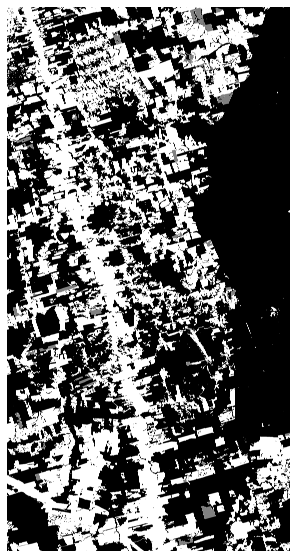

In [38]:
fig1 = plt.figure(figsize=(10,10))
plt.imshow(label_mask, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

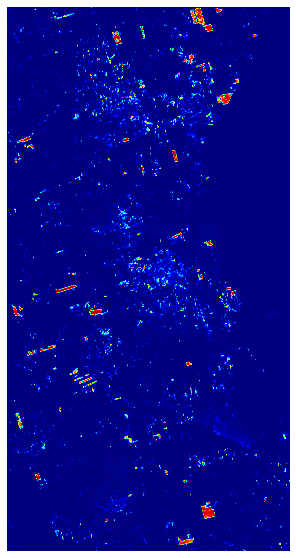

In [39]:
mean_prob = mean_prob.copy()
mean_prob[label_mask == 2] = 0
fig1 = plt.figure(figsize=(10,10))
plt.imshow(mean_prob, cmap = 'jet')
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [40]:
# print(np.unique(label_mask, return_counts=True))
print(label_mask.shape)

(17730, 9200)


In [41]:
label_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob[mask_amazon_ts == 1]
mean_prob_test = mean_prob_test[label_test != 2]
label_test = label_test[label_test != 2]

print(label_test.shape)
print(np.unique(label_test, return_counts=True))

(54236371,)
(array([0, 1], dtype=uint8), array([53470765,   765606], dtype=int64))


In [42]:
from sklearn import metrics
mAP = round(metrics.average_precision_score(label_test, 
        mean_prob_test)*100, 2)
print(mAP)

87.44


In [43]:
from icecream import ic

ic(prob_rec.shape)
prob_rec = np.transpose(prob_rec, (2, 0, 1))


ic| prob_rec.shape: (17760, 9216, 10)


In [44]:
prob_rec = np.expand_dims(prob_rec, axis = -1)

In [45]:
ic(prob_rec.shape)

ic| prob_rec.shape: (10, 17760, 9216, 1)


(10, 17760, 9216, 1)

In [46]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

epsilon = 1e-15
def show_im(im, ax, title = "", cmap = "jet"):
    im_plt = ax.imshow(im.astype(np.float32), cmap = cmap)
    plt.title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im_plt, cax=cax) 

def get_mean(pred_probs):
      return np.mean(pred_probs, axis=0)
    
def get_uncertainty_var(pred_probs):
    return np.var(pred_probs, axis=0)
    
def predictive_variance(pred_probs):
    pred_var = get_uncertainty_var(pred_probs)
    pred_var = np.average(pred_var, axis = -1)
#    ic(pred_var.shape)
    return pred_var

def predictive_entropy(pred_probs):
    pred_mean = get_mean(pred_probs) # shape (patch_len, patch_len, class_n)
    pred_entropy = np.zeros((pred_mean.shape[0:2]))

    K = pred_mean.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_mean[..., k] * np.log(pred_mean[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy


def single_experiment_entropy(pred_prob):
    pred_entropy = np.zeros(pred_prob.shape[0:2])
    ic(pred_entropy.shape)
    
    K = pred_prob.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_prob[..., k] * np.log(pred_prob[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy

def mutual_information(pred_probs):
    H = predictive_entropy(pred_probs)
    sum_entropy = 0

    n = pred_probs.shape[0]
    K = pred_probs.shape[-1]
    ic(n, K)

    for i in range(n):
        for k in range(K):
            sum_entropy = sum_entropy + pred_probs[i, ..., k] * np.log(pred_probs[i, ..., k] + epsilon)

    sum_entropy = - sum_entropy / (n * K)

    MI = H - sum_entropy
    return MI

In [47]:
'''
pred_var = predictive_variance(prob_rec)

fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_var, ax, title = 'Uncertainty predictive varance')
'''

"\npred_var = predictive_variance(prob_rec)\n\nfig, ax = plt.subplots(1,1,figsize=(10,10))\nshow_im(pred_var, ax, title = 'Uncertainty predictive varance')\n"

In [48]:
pred_entropy = predictive_entropy(prob_rec).astype(np.float32)
pred_entropy_to_show = pred_entropy.copy()[:label_mask.shape[0], :label_mask.shape[1]]

pred_entropy_to_show[label_mask == 2] = 0



In [49]:
prob_rec.shape

(10, 17760, 9216, 1)

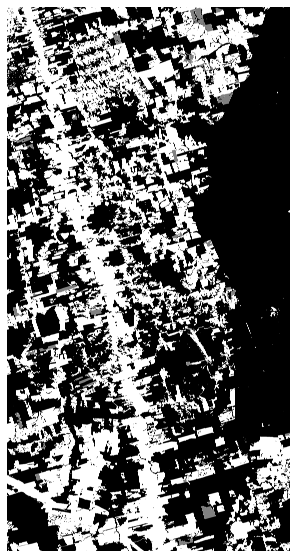

In [50]:
fig1 = plt.figure(figsize=(10,10))
plt.imshow(label_mask, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

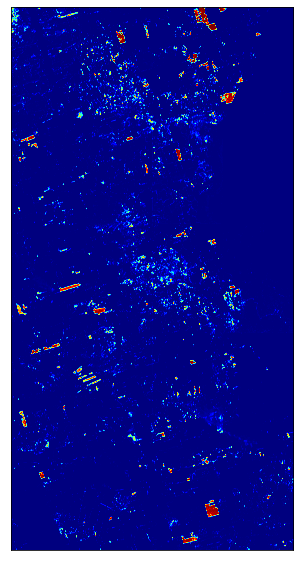

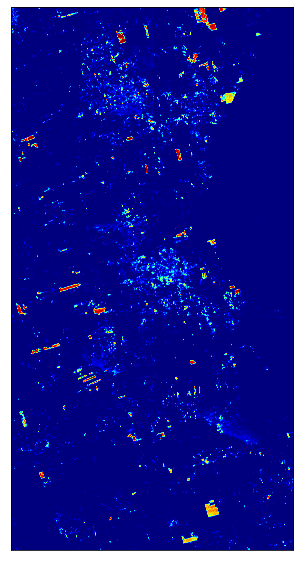

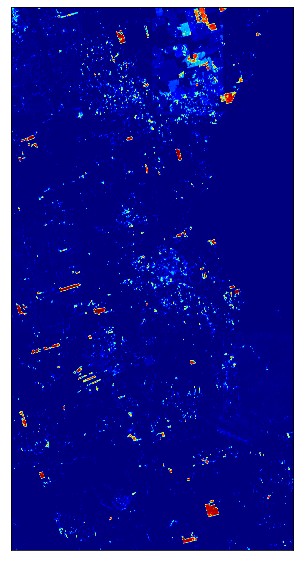

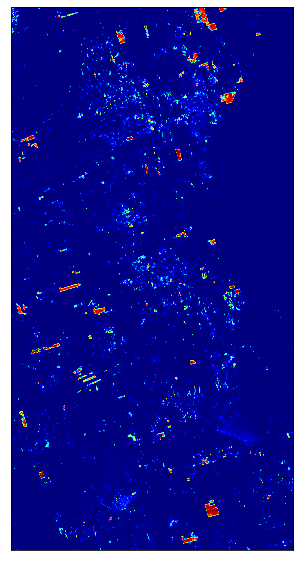

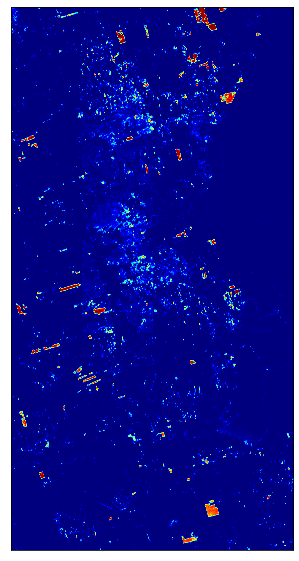

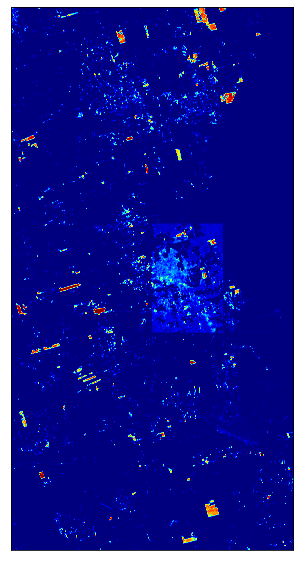

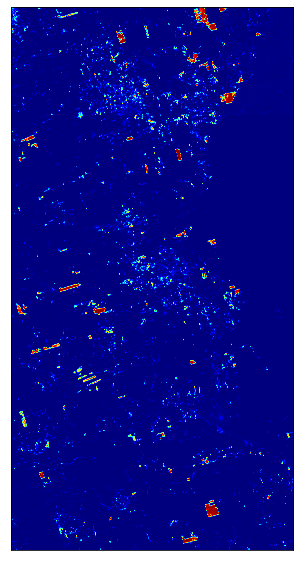

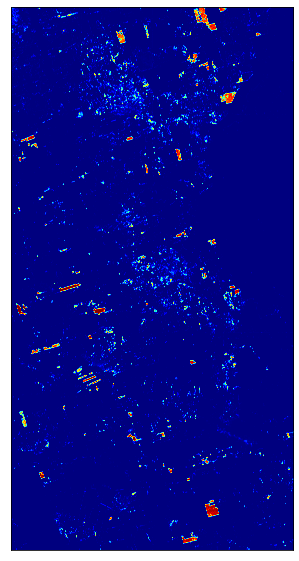

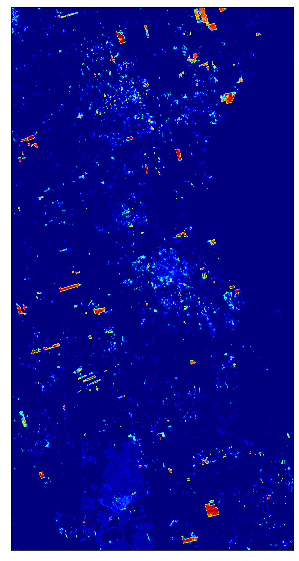

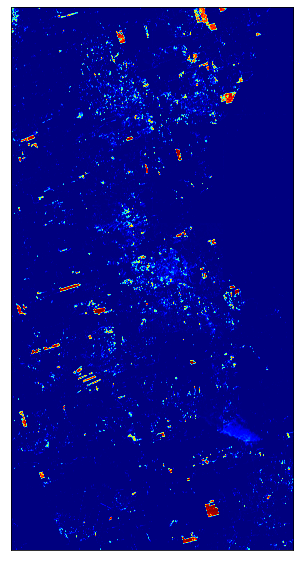

In [51]:
# Computing error mask
# label_mask

for idx in range(10):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(prob_rec[idx], cmap = 'jet')
# fig.savefig('figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')


(-0.5, 9199.5, 17729.5, -0.5)

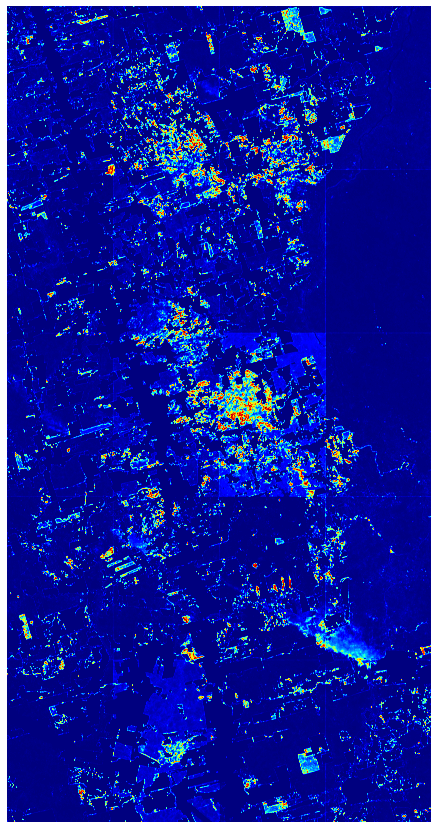

In [52]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy_to_show, cmap='jet')
# show_im(pred_entropy_to_show, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
#plt.savefig('figures/Para' + title_name + ' uncertainty predictive entropy.png', 
 #   dpi=150, bbox_inches='tight')

In [53]:
ic(pred_entropy.shape)


ic| pred_entropy.shape: (17760, 9216)


(17760, 9216)

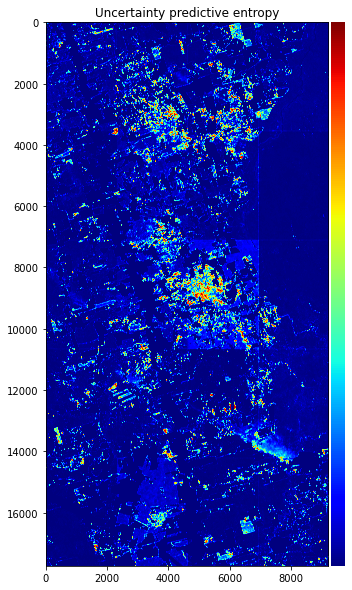

In [54]:
pred_entropy_to_show = pred_entropy[:label_mask.shape[0], :label_mask.shape[1]].copy()
pred_entropy_to_show[label_mask == 2] = 0
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_entropy_to_show, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' uncertainty predictive entropy.png', 
    dpi=150, bbox_inches='tight')

In [55]:

'''
pred_entropy_single = single_experiment_entropy(prob_rec[0])

fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_entropy_single, ax, title = 'Uncertainty predictive entropy single sample')
'''


"\npred_entropy_single = single_experiment_entropy(prob_rec[0])\n\nfig, ax = plt.subplots(1,1,figsize=(10,10))\nshow_im(pred_entropy_single, ax, title = 'Uncertainty predictive entropy single sample')\n"

In [56]:

'''
MI = mutual_information(prob_rec)

fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(MI, ax, title = 'Uncertainty MI')
'''


"\nMI = mutual_information(prob_rec)\n\nfig, ax = plt.subplots(1,1,figsize=(10,10))\nshow_im(MI, ax, title = 'Uncertainty MI')\n"

(array([0, 1, 2], dtype=uint8), array([81558000, 65246400, 16311600], dtype=int64))


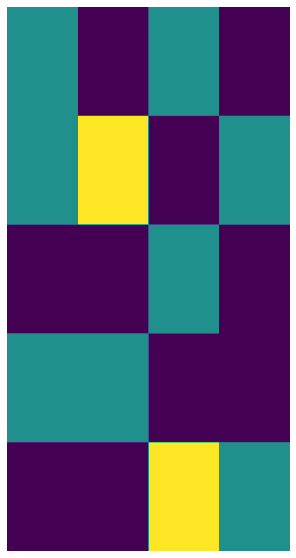

In [57]:
# mask_tr_val = test 0, train 1, val 2. 
# mask_ts = test 1.
print(np.unique(mask_tr_val, return_counts=True))
plt.figure(figsize=(10,10))
plt.imshow(mask_tr_val)
plt.axis('off')
plt.savefig('figures/Train val mask.png', dpi=200, bbox_inches='tight')



In [58]:
label_mask_current_deforestation = label_mask.copy()
label_mask_current_deforestation[label_mask_current_deforestation==2] = 0

In [59]:
label_mask_current_deforestation_to_show = label_mask_current_deforestation.copy()
label_mask_current_deforestation_to_show = np.abs(
        label_mask_current_deforestation_to_show - 1)
ic(np.unique(label_mask_current_deforestation_to_show, return_counts=True))

ic| np.unique(label_mask_current_deforestation_to_show, return_counts=True): (array([  0, 255], dtype=uint8), array([  1838508, 161277492], dtype=int64))


(array([  0, 255], dtype=uint8), array([  1838508, 161277492], dtype=int64))

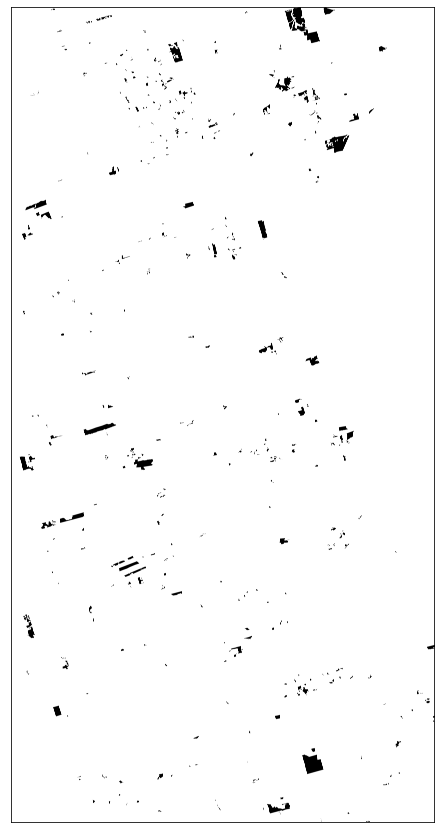

In [60]:
# Computing error mask
# label_mask

fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(label_mask_current_deforestation_to_show, cmap = plt.cm.gray)
fig.savefig('figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')




In [61]:


label_mask_val = label_mask[mask_tr_val == 2]
ic(label_mask_val.shape)

mean_prob_val = mean_prob[mask_tr_val == 2]

mean_prob_val = mean_prob_val[label_mask_val != 2]
label_mask_val_valid = label_mask_val[label_mask_val != 2]
ic(label_mask_val_valid.shape)



ic| label_mask_val.shape: (16311600,)
ic| label_mask_val_valid.shape: (9450701,)


(9450701,)

In [62]:
from sklearn import metrics
pos_label = 1
precision, recall, thresholds = metrics.precision_recall_curve(
            label_mask_val_valid, mean_prob_val, pos_label=pos_label)



In [63]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
best_threshold = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.696036, F-Score=0.832


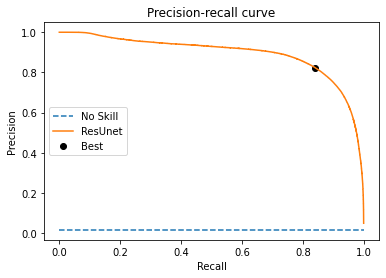

In [64]:
importlib.reload(_metrics)
_metrics.plotPrecisionRecall(label_mask_val, precision, recall, ix)
plt.savefig('figures/' + 'Para_prediction_recall_curve.png', dpi=150, bbox_inches='tight')

In [65]:
print(mean_prob.shape)
predicted = np.zeros_like(mean_prob)
# threshold = 0.5
threshold = best_threshold
# threshold = 0.46
# threshold = 0.57
# threshold = 0.5624
# threshold = 0.43
predicted[mean_prob>=threshold] = 1
predicted[mean_prob<threshold] = 0

print(np.unique(predicted, return_counts=True))

predicted_unpad = predicted.copy()
ic(predicted_unpad.shape, predicted.shape)
del predicted

(17730, 9200)


ic| predicted_unpad.shape: (17730, 9200)
    predicted.shape: (17730, 9200)


(array([0., 1.], dtype=float32), array([161490456,   1625544], dtype=int64))


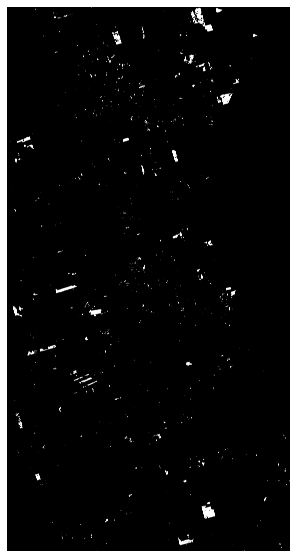

In [66]:

plt.figure(figsize=(10,10))
plt.imshow(predicted_unpad, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' predicted.png', dpi=150, bbox_inches='tight')


In [67]:

# mean_prob_unpad = mean_prob[:-npad[0][1], :-npad[1][1]]

In [68]:
# mean_prob_unpad.shape

In [69]:
# ic(mask_amazon_ts.shape)
# mask_amazon_ts = mask_amazon_ts[:-npad[0][1], :-npad[1][1]]


In [70]:
# ic(mask_amazon_ts.shape, predicted_unpad.shape)
# label_mask_current_deforestation = label_mask_current_deforestation[:-npad[0][1], :-npad[1][1]]

In [71]:
# label_mask = label_mask[:-npad[0][1], :-npad[1][1]]

In [72]:
import importlib
import utils_v1
importlib.reload(utils_v1)

<module 'utils_v1' from 'd:\\Jorge\\deforestation_uncertainty\\utils_v1.py'>

In [73]:
ic(predicted_unpad.shape, label_mask_current_deforestation.shape,
    mask_amazon_ts.shape, label_mask.shape, mean_prob.shape)

ic| predicted_unpad.shape: (17730, 9200)
    label_mask_current_deforestation.shape: (17730, 9200)
    mask_amazon_ts.shape: (17730, 9200)
    label_mask.shape: (17730, 9200)
    mean_prob.shape: (17730, 9200)


((17730, 9200), (17730, 9200), (17730, 9200), (17730, 9200), (17730, 9200))

In [74]:
# test metrics
from sklearn.metrics import f1_score

predicted_test = predicted_unpad[mask_amazon_ts == 1]
label_mask_current_deforestation_test = label_mask_current_deforestation[mask_amazon_ts == 1]
label_mask_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob[mask_amazon_ts == 1]

ic(predicted_test.shape)

predicted_test = utils_v1.excludeBackgroundAreasFromTest(
        predicted_test, label_mask_test)
label_mask_current_deforestation_test = utils_v1.excludeBackgroundAreasFromTest(
        label_mask_current_deforestation_test, label_mask_test)
mean_prob_test = utils_v1.excludeBackgroundAreasFromTest(
        mean_prob_test, label_mask_test)

ic(predicted_test.shape)

deforestationMetricsGet = True
if deforestationMetricsGet == True:
        f1 = round(f1_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        precision = round(precision_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        recall = round(recall_score(label_mask_current_deforestation_test, predicted_test)*100, 2)

        mAP = round(metrics.average_precision_score(label_mask_current_deforestation_test, 
                mean_prob_test)*100, 2)

        ic(f1, precision, recall, mAP)

ic| predicted_test.shape: (81558000,)
ic| predicted_test.shape: (54236371,)
ic| f1: 79.22, precision: 83.51, recall: 75.35, mAP: 87.44


In [75]:
ic(f1, precision, recall, mAP)

ic| f1: 79.22, precision: 83.51, recall: 75.35, mAP: 87.44


(79.22, 83.51, 75.35, 87.44)

### Metrics for validation set in forest/deforestation detection

In [76]:
ic(mask_tr_val.shape)

ic| mask_tr_val.shape: (17730, 9200)


(17730, 9200)

In [77]:
predicted_val = predicted_unpad[mask_tr_val == 2]
predicted_val = predicted_val[label_mask_val != 2]

In [78]:

f1_val = round(f1_score(label_mask_val_valid, predicted_val)*100, 2)
precision_val = round(precision_score(label_mask_val_valid, predicted_val)*100, 2)
recall_val = round(recall_score(label_mask_val_valid, predicted_val)*100, 2)

mAP_val = round(metrics.average_precision_score(label_mask_val_valid, mean_prob_val)*100, 2)


ic(f1_val, precision_val, recall_val, mAP_val)

ic| f1_val: 83.21
    precision_val: 82.4
    recall_val: 84.03
    mAP_val: 89.34


(83.21, 82.4, 84.03, 89.34)

In [79]:

error_mask = np.abs(predicted_unpad - label_mask_current_deforestation)
print(np.unique(error_mask, return_counts=True))


(array([0., 1.], dtype=float32), array([162390740,    725260], dtype=int64))


In [80]:
false_positive_mask = predicted_unpad - label_mask_current_deforestation
ic(false_positive_mask.shape)
ic(np.unique(false_positive_mask, return_counts=True))
# 0 class 0, 1 class 1, 2 false positive, 3 false negative
# colormap black, white, blue, red.



ic| false_positive_mask.shape: (17730, 9200)
ic| np.unique(false_positive_mask, return_counts=True): (array([-1.,  0.,  1.], dtype=float32),
                                                         array([   469112, 162390740,    256148], dtype=int64))


(array([-1.,  0.,  1.], dtype=float32),
 array([   469112, 162390740,    256148], dtype=int64))

In [81]:
ic(predicted_unpad.shape, label_mask.shape)

ic| predicted_unpad.shape: (17730, 9200)
    label_mask.shape: (17730, 9200)


((17730, 9200), (17730, 9200))

In [82]:

importlib.reload(_metrics)

prediced_unpad_to_show = predicted_unpad.copy()
prediced_unpad_to_show[label_mask == 2] = 0

error_mask_to_show = _metrics.getRgbErrorMask(prediced_unpad_to_show, 
        label_mask_current_deforestation).astype(np.uint8)
error_mask_to_show_rgb = _metrics.saveRgbErrorMask(error_mask_to_show).astype(np.uint8)
del error_mask_to_show
cv2.imwrite('figures/Para_error_mask_to_show_rgb.png', error_mask_to_show_rgb)

# ,
#        dim = (617, 1162)


True

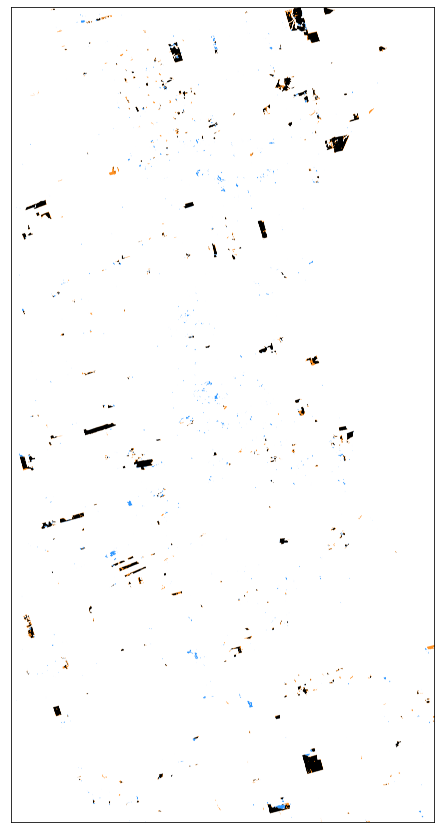

In [83]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])

ax.imshow(error_mask_to_show_rgb[...,::-1])

fig.savefig('figures/Para' + title_name + ' error mask color.png', dpi=300, bbox_inches='tight')


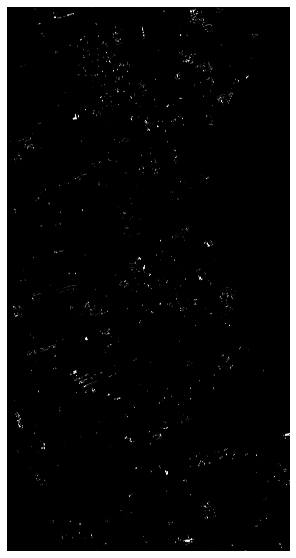

In [84]:
plt.figure(figsize=(10,10))
plt.imshow(error_mask, cmap=plt.cm.gray)
title_name = 'ResUnet'
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [85]:
import importlib
import utils_v1
importlib.reload(utils_v1)

<module 'utils_v1' from 'd:\\Jorge\\deforestation_uncertainty\\utils_v1.py'>

In [86]:
ic(label_mask.shape)
ic(mask_amazon_ts.shape)
 
label_mask_test = utils_v1.getTestVectorFromIm(
        label_mask, mask_amazon_ts)        
ic(label_mask_test.shape)

error_mask_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
        error_mask, mask_amazon_ts),
        label_mask_test) 


error_mask_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
        error_mask, mask_tr_val, mask_return_value = 2),
        label_mask_val) 

 
ic(error_mask_test.shape)

ic| label_mask.shape: (17730, 9200)
ic| mask_amazon_ts.shape: (17730, 9200)
ic| label_mask_test.shape: (81558000,)
ic| error_mask_test.shape: (54236371,)


(54236371,)

In [87]:
# ic(pred_entropy[:-npad[0][1], :-npad[1][1]][:-npad[0][1], :-npad[1][1]].shape)

In [88]:
     

ic(pred_entropy.shape, utils_v1.unpadIm(pred_entropy, npad).shape, 
    mask_amazon_ts.shape, label_mask_test.shape)
pred_entropy_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy, npad), mask_amazon_ts),
        label_mask_test)
  





ic| pred_entropy.shape: (17760, 9216)
    utils_v1.unpadIm(pred_entropy, npad).shape: (17730, 9200)
    mask_amazon_ts.shape: (17730, 9200)
    label_mask_test.shape: (81558000,)


In [89]:
pred_entropy_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

In [90]:
from enum import Enum
Predictor = Enum('Predictor', 'pred_var MI pred_entropy pred_entropy_single')
predictor = Predictor.pred_entropy
# predictor = Predictor.pred_var
# predictor = Predictor.pred_entropy_single
# predictor = Predictor.MI

if predictor == Predictor.pred_var:
    y_pred = pred_var_test
    y_pred_val = pred_var_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Variance'
    best_threshold = 0.2
elif predictor == Predictor.MI:
    y_pred = MI_test
    y_pred_val = MI_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Mutual Information'
    best_threshold = 0.2
elif predictor == Predictor.pred_entropy:
    y_pred = pred_entropy_test
    y_pred_val = pred_entropy_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy'
    best_threshold = 0.287
elif predictor == Predictor.pred_entropy_single:
    y_pred = pred_entropy_single_test
    y_pred_val = pred_entropy_single_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy Single'
    best_threshold = 0.287


In [91]:

y_test = error_mask_test
y_val = error_mask_val

ic(y_test.shape, y_pred.shape)
pos_label = 1
ROCmode = 'val'
if ROCmode == 'test':
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=pos_label)
elif ROCmode == 'val':
    fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred_val, pos_label=pos_label)

roc_auc = metrics.auc(fpr, tpr)
ic(roc_auc)

ic| y_test.shape: (54236371,), y_pred.shape: (54236371,)
ic| roc_auc: 0.9451019958981544


0.9451019958981544

Best Threshold=0.069532, G-Mean=0.910


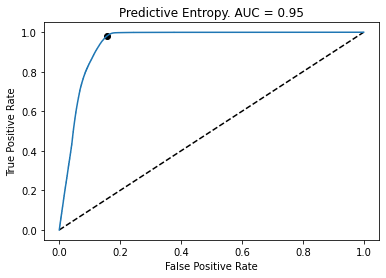

In [92]:
importlib.reload(_metrics)
plt.figure()
_metrics.plotAUC(fpr, tpr, roc_auc, modelId = title_name)
ix, best_threshold_uncertainty = _metrics.getBestThresholdGMean(fpr, tpr, thresholds)
# ix, best_threshold_uncertainty = _metrics.getBestThresholdJStatistic(fpr, tpr, thresholds)

_metrics.plotBestThreshold(fpr, tpr, ix)
plt.savefig(figures_path + title_name + ' roc_curve.png', dpi=200)

In [93]:
np.set_printoptions(suppress=False)
ic(best_threshold_uncertainty)
np.set_printoptions(suppress=True)


ic| best_threshold_uncertainty: 0.069531955


In [94]:
# best_threshold_uncertainty = 0.262948
# best_threshold_uncertainty = 0.08329400420188904

In [95]:
# threshold = 0.003254
y_pred_thresholded = np.zeros_like(y_pred)
y_pred_thresholded[y_pred >= best_threshold_uncertainty] = 1


In [96]:
metrics_error_detection = False
if metrics_error_detection == True:
    f1 = round(f1_score(error_mask_test, y_pred_thresholded)*100, 2)
    precision = round(metrics.precision_score(error_mask_test, y_pred_thresholded)*100, 2)
    recall = round(metrics.recall_score(error_mask_test, y_pred_thresholded)*100, 2)
    ic(f1, precision, recall)

    cm = metrics.confusion_matrix(error_mask_test, y_pred_thresholded)
    print(cm)

In [97]:
if metrics_error_detection == True:

    ic(best_threshold_uncertainty)

In [98]:
if metrics_error_detection == True:

    predicted_error_mask = np.zeros(pred_entropy.shape, dtype = np.uint8)
    predicted_error_mask[pred_entropy>=best_threshold_uncertainty] = 1
    predicted_error_mask = utils_v1.unpadIm(predicted_error_mask, npad)

    predicted_error_mask[label_mask == 2] = 0

In [99]:
if metrics_error_detection == True:

    # ic(np.unique(predicted_error_mask, return_counts=True))
    # ic(np.unique(error_mask, return_counts=True))
    predicted_error_mask_to_show = predicted_error_mask.copy()
    predicted_error_mask_to_show = np.abs(1 - predicted_error_mask_to_show)
    predicted_error_mask_to_show = predicted_error_mask_to_show.astype(np.uint8)*255
    predicted_error_mask_to_show = np.repeat(
        np.expand_dims(predicted_error_mask_to_show, axis=-1),
        3, axis = -1)
    fig, ax = plt.subplots(figsize=(15,15))
    ax.set_xticks([])
    ax.set_yticks([])

    ax.imshow(predicted_error_mask_to_show)


    title_name = 'ResUnet'
    fig.savefig('figures/Para' + title_name + 'predicted error mask.png', dpi=300, bbox_inches='tight')


In [100]:
if metrics_error_detection == True:

    predicted_error_mask_forest = predicted_error_mask.copy()
    predicted_error_mask_forest[predicted_unpad == 1] = 0
    ic(np.unique(predicted_unpad, return_counts=True))
    ic(np.unique(predicted_error_mask_forest, return_counts=True))

    plt.figure(figsize=(10,10))
    plt.imshow(predicted_error_mask, cmap=plt.cm.gray)
    title_name = 'ResUnet'
    plt.axis('off')
    plt.savefig('figures/Para' + title_name + 'predicted error mask forest.png', dpi=150, bbox_inches='tight')


In [101]:
if metrics_error_detection == True:

        importlib.reload(_metrics)
        _metrics.plotConfusionMatrix(cm)
        plt.savefig(figures_path + title_name + ' confusion matrix ROC threshold.png', 
                dpi=200, bbox_inches='tight')

In [102]:
label_mask_current_deforestation_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                label_mask_current_deforestation, mask_amazon_ts),
        label_mask_test)

predicted_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                predicted_unpad, mask_amazon_ts),
        label_mask_test)
        


## Get 2x2 forest/deforestation confusion matrices for correct and incorrect samples

In [103]:
if metrics_error_detection == True:

    # predicted_test is the prediction of no deforestation vs. deforestation
    # label_mask_current_deforestation_test
    # y_pred, y_pred_thresholded
    ic(np.unique(y_pred_thresholded, return_counts=True))
    ic(predicted_test.shape, y_pred_thresholded.shape, label_mask_current_deforestation_test.shape)

    predicted_test_classified_correct = predicted_test[y_pred_thresholded == 0]
    label_current_deforestation_test_classified_correct = label_mask_current_deforestation_test[y_pred_thresholded == 0]

    predicted_test_classified_incorrect = predicted_test[y_pred_thresholded == 1]
    label_current_deforestation_test_classified_incorrect = label_mask_current_deforestation_test[y_pred_thresholded == 1]

    ic(np.unique(predicted_test_classified_correct, return_counts=True))
    ic(np.unique(label_current_deforestation_test_classified_correct, return_counts=True))
    ic(np.unique(predicted_test_classified_incorrect, return_counts=True))
    ic(np.unique(label_current_deforestation_test_classified_incorrect, return_counts=True))

In [104]:
if metrics_error_detection == True:

    cm_correct = metrics.confusion_matrix(label_current_deforestation_test_classified_correct,
        predicted_test_classified_correct)
    ic(cm_correct)

In [105]:
if metrics_error_detection == True:

        _metrics.plotConfusionMatrix(cm_correct, 
                target_names = ['Forest', 'Deforestation'])
        plt.title('Classified as correct')
        plt.savefig(figures_path + title_name + ' confusion matrix correct.png', 
                dpi=200, bbox_inches='tight')

In [106]:
if metrics_error_detection == True:

    cm_incorrect = metrics.confusion_matrix(label_current_deforestation_test_classified_incorrect,
        predicted_test_classified_incorrect)
    ic(cm_incorrect)

In [107]:
if metrics_error_detection == True:

        _metrics.plotConfusionMatrix(cm_incorrect, 
                target_names = ['Forest', 'Deforestation'])
        plt.title('Classified as incorrect')
        plt.savefig(figures_path + title_name + ' confusion matrix incorrect.png', 
                dpi=200, bbox_inches='tight')

Get precision-recall threshold

In [108]:
precision, recall, thresholds = metrics.precision_recall_curve(
            y_val, y_pred_val, pos_label=pos_label)



In [109]:
ic(thresholds)

ic| thresholds: array([0.00692202, 0.00692203, 0.00692204, ..., 0.36787942, 0.36787945,
                       0.36787948], dtype=float32)


array([0.00692202, 0.00692203, 0.00692204, ..., 0.36787942, 0.36787945,
       0.36787948], dtype=float32)

In [110]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
best_threshold_uncertainty = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.206847, F-Score=0.167


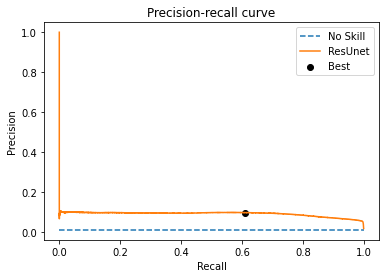

In [111]:
importlib.reload(_metrics)
_metrics.plotPrecisionRecall(y_val, precision, recall, ix)
plt.savefig('figures/' + 'Para' + 'prediction_recall_curve.png', dpi=150, bbox_inches='tight')

In [112]:
'''
# Metrics for th=0.5    
ProbList_05 = [0.5]

metrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)
print('Metrics th = 0.5: ', metrics_05*100)
'''


"\n# Metrics for th=0.5    \nProbList_05 = [0.5]\n\nmetrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)\nprint('Metrics th = 0.5: ', metrics_05*100)\n"

In [113]:
ic(np.min(y_pred), np.average(y_pred), np.max(y_pred))

ic| np.min(y_pred): 3.457823e-07
    np.average(y_pred): 0.031116119
    np.max(y_pred): 0.36787948


(3.457823e-07, 0.031116119, 0.36787948)

In [114]:
ic(y_pred.dtype, label_mask_current_deforestation_test.dtype, predicted_test.dtype)

ic| y_pred.dtype: dtype('float32')
    label_mask_current_deforestation_test.dtype: dtype('uint8')
    predicted_test.dtype: dtype('float32')


(dtype('float32'), dtype('uint8'), dtype('float32'))

In [115]:
importlib.reload(_metrics)

threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

loadThresholdMetrics = False
if loadThresholdMetrics == False:
        # threshold_list = [0.1]
        # y_test
        ic(y_pred.shape, label_mask_current_deforestation_test.shape)
        importlib.reload(_metrics)

        metrics_values = _metrics.getAA_Recall(y_pred, 
                label_mask_current_deforestation_test, 
                predicted_test, threshold_list)

        ic(metrics_values)



ic| y_pred.shape: (54236371,)
    label_mask_current_deforestation_test.shape: (54236371,)


threshold 0.01
(34816604,) (34816604,)
cm_correct [[34812926        0]
 [    3678        0]]
(19419767,) (19419767,)
cm_incorrect [[18543930   113909]
 [  185006   576922]]
[       nan 0.         0.         0.35805801 0.83511307 0.75718703]
threshold 0.015


d:\Jorge\deforestation_uncertainty\src\metrics.py:254: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_L = TP_L / (TP_L + FP_L)


(38433560,) (38433560,)
cm_correct [[38428658        0]
 [    4827       75]]
(15802811,) (15802811,)
cm_incorrect [[14928198   113909]
 [  183857   576847]]
[1.         0.01529988 0.00009796 0.29136925 0.83509517 0.75830678]
threshold 0.025
(42660409,) (42660409,)
cm_correct [[42643433        0]
 [    6455    10521]]
(11575962,) (11575962,)
cm_incorrect [[10713423   113909]
 [  182229   566401]]
[1.         0.6197573  0.01374206 0.21343541 0.8325631  0.75658336]
threshold 0.05
(46615060,) (46615060,)
cm_correct [[46496217      149]
 [    8636   110058]]
(7621311,) (7621311,)
cm_incorrect [[6860639  113760]
 [ 180048  466864]]
[0.998648   0.92724148 0.14375279 0.1405203  0.80407286 0.72168085]
threshold 0.08
(48539056,) (48539056,)
cm_correct [[48273342     1853]
 [   10179   253682]]
(5697315,) (5697315,)
cm_incorrect [[5083514  112056]
 [ 178505  323240]]
[0.99274855 0.96142287 0.33134798 0.10504602 0.74257517 0.64423163]
threshold 0.1
(49391253,) (49391253,)
cm_correct [[49047965   

d:\Jorge\deforestation_uncertainty\src\metrics.py:257: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)


(52948081,) (52948081,)
cm_correct [[52181242   113909]
 [   76008   576922]]
(1288290,) (1288290,)
cm_incorrect [[1175614       0]
 [ 112676       0]]
[0.83511307 0.88358936 0.75354948 0.02375325        nan 0.        ]
threshold 0.34


d:\Jorge\deforestation_uncertainty\src\metrics.py:257: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)


(53491585,) (53491585,)
cm_correct [[52677371   113909]
 [  123383   576922]]
(744786,) (744786,)
cm_incorrect [[679485      0]
 [ 65301      0]]
[0.83511307 0.82381534 0.75354948 0.01373222        nan 0.        ]
threshold 0.36


d:\Jorge\deforestation_uncertainty\src\metrics.py:257: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)


(53863029,) (53863029,)


d:\Jorge\deforestation_uncertainty\src\metrics.py:257: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| metrics_values: array([[       nan, 0.        , 0.        , 0.35805801, 0.83511307,
                            0.75718703],
                           [1.        , 0.01529988, 0.00009796, 0.29136925, 0.83509517,
                            0.75830678],
                           [1.        , 0.6197573 , 0.01374206, 0.21343541, 0.8325631 ,
                            0.75658336],
                           [0.998648  , 0.92724148, 0.14375279, 0.1405203 , 0.80407286,
                            0.72168085],
                           [0.99274855, 0.96142287, 0.33134798, 0.10504602, 0.74257517,
                            0.64423163],
                           [0.98488575, 0.96703501, 0.42726546, 0.08933337, 0.69642927,
                            0.5845607 ],
                           [0.94993268, 0.96978248, 0.57684632, 0.064178

cm_correct [[53016579   113909]
 [  155619   576922]]
(373342,) (373342,)
cm_incorrect [[340277      0]
 [ 33065      0]]
[0.83511307 0.78756274 0.75354948 0.00688361        nan 0.        ]


In [116]:

if loadThresholdMetrics == False:
        # threshold_list = [0.1]
        # y_test
        ic(y_pred.shape, label_mask_current_deforestation_test.shape)
        importlib.reload(_metrics)

        metric_values_audited = _metrics.getUncertaintyMetricsAudited(y_pred, 
                label_mask_current_deforestation_test, 
                predicted_test, threshold_list)

        ic(metric_values_audited)



ic| y_pred.shape: (54236371,)
    label_mask_current_deforestation_test.shape: (54236371,)


threshold 0.01
(54236371,) (54236371,)
cm_audited [[53470765        0]
 [    3678   761928]]
[1.         0.99519596]
threshold 0.015
(54236371,) (54236371,)
cm_audited [[53470765        0]
 [    4827   760779]]
[1.         0.99369519]
threshold 0.025
(54236371,) (54236371,)
cm_audited [[53470765        0]
 [    6455   759151]]
[1.         0.99156877]
threshold 0.05
(54236371,) (54236371,)
cm_audited [[53470616      149]
 [    8636   756970]]
[0.9998032  0.98872005]
threshold 0.08
(54236371,) (54236371,)
cm_audited [[53468912     1853]
 [   10179   755427]]
[0.99755308 0.98670465]
threshold 0.1
(54236371,) (54236371,)
cm_audited [[53465745     5020]
 [   11151   754455]]
[0.99339017 0.98543507]
threshold 0.15
(54236371,) (54236371,)
cm_audited [[53447488    23277]
 [   13761   751845]]
[0.96996989 0.982026  ]
threshold 0.2
(54236371,) (54236371,)
cm_audited [[53413740    57025]
 [   17612   747994]]
[0.92916316 0.976996  ]
threshold 0.25
(54236371,) (54236371,)
cm_audited [[53359814   1

ic| metric_values_audited: array([[1.        , 0.99519596],
                                  [1.        , 0.99369519],
                                  [1.        , 0.99156877],
                                  [0.9998032 , 0.98872005],
                                  [0.99755308, 0.98670465],
                                  [0.99339017, 0.98543507],
                                  [0.96996989, 0.982026  ],
                                  [0.92916316, 0.976996  ],
                                  [0.87006497, 0.97040122],
                                  [0.86383073, 0.9438484 ],
                                  [0.85823521, 0.90072178],
                                  [0.84935302, 0.83884269],
                                  [0.84264452, 0.79673749]])


cm_audited [[53356856   113909]
 [  155619   609987]]
[0.84264452 0.79673749]


In [117]:
m_audited = {'precision': metric_values_audited[:,0],
        'recall': metric_values_audited[:,1]}



In [118]:
'''
threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]
importlib.reload(_metrics)

metrics = _metrics.getF1byThreshold(y_pred,
    error_mask, threshold_list)

ic(metrics)
'''

'\nthreshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]\nimportlib.reload(_metrics)\n\nmetrics = _metrics.getF1byThreshold(y_pred,\n    error_mask, threshold_list)\n\nic(metrics)\n'

In [119]:
if loadThresholdMetrics == False:

    np.save('metrics.npy', metrics_values)
if loadThresholdMetrics == True:
    metrics_values = np.load('metrics.npy')


In [120]:
save_figures = True

In [121]:
m = {'precision_L': metrics_values[:,0],
        'recall_L': metrics_values[:,1],
        'recall_Ltotal': metrics_values[:,2],
        'AA': metrics_values[:,3],
        'precision_H': metrics_values[:,4],
        'recall_H': metrics_values[:,5]}



In [122]:
threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]


In [123]:
# m['precision_H'] = np.nan_to_num(m['precision_H'], nan=0)

In [124]:
'''
m = {'precision_L': metrics[1:,0],
        'recall_L': metrics[1:,1],
        'recall_Ltotal': metrics[1:,2],
        'AA': metrics[1:,3],
        'precision_H': metrics[1:,4],
        'recall_H': metrics[1:,5]}

threshold_list = [0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]
'''

"\nm = {'precision_L': metrics[1:,0],\n        'recall_L': metrics[1:,1],\n        'recall_Ltotal': metrics[1:,2],\n        'AA': metrics[1:,3],\n        'precision_H': metrics[1:,4],\n        'recall_H': metrics[1:,5]}\n\nthreshold_list = [0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]\n"

In [125]:
'''
plt.plot(m['recall_L']*100, m['AA']*100)
plt.title('Recall vs. To-Audit Area')
plt.xlabel('Recall (%)')
plt.ylabel('Audit Area (%)')
if save_figures == True:
    plt.savefig('figures/recall_AA.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m['recall_L']*100, m['AA']*100)\nplt.title('Recall vs. To-Audit Area')\nplt.xlabel('Recall (%)')\nplt.ylabel('Audit Area (%)')\nif save_figures == True:\n    plt.savefig('figures/recall_AA.png', dpi=150, bbox_inches='tight')\n"

In [126]:
'''
plt.plot(m['precision_L']*100, m['AA']*100)
plt.title('Precision vs. To-Audit Area')
plt.xlabel('Precision (%)')
plt.ylabel('Audit Area (%)')
if save_figures == True:
    plt.savefig('figures/precision_AA.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m['precision_L']*100, m['AA']*100)\nplt.title('Precision vs. To-Audit Area')\nplt.xlabel('Precision (%)')\nplt.ylabel('Audit Area (%)')\nif save_figures == True:\n    plt.savefig('figures/precision_AA.png', dpi=150, bbox_inches='tight')\n"

In [127]:
'''
plt.plot(m['recall_Ltotal']*100, m['AA']*100)
plt.title('Recall total vs. To-Audit Area')
plt.xlabel('Recall (%)')
plt.ylabel('Audit Area (%)')
if save_figures == True:
    plt.savefig('figures/recall_total_AA.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m['recall_Ltotal']*100, m['AA']*100)\nplt.title('Recall total vs. To-Audit Area')\nplt.xlabel('Recall (%)')\nplt.ylabel('Audit Area (%)')\nif save_figures == True:\n    plt.savefig('figures/recall_total_AA.png', dpi=150, bbox_inches='tight')\n"

In [128]:
'''
plt.plot(m['recall_L']*100, np.asarray(threshold_list))
plt.title('Recall vs. Threshold')
plt.xlabel('Recall (%)')
plt.ylabel('Threshold')
if save_figures == True:
    plt.savefig('figures/recall_threshold.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m['recall_L']*100, np.asarray(threshold_list))\nplt.title('Recall vs. Threshold')\nplt.xlabel('Recall (%)')\nplt.ylabel('Threshold')\nif save_figures == True:\n    plt.savefig('figures/recall_threshold.png', dpi=150, bbox_inches='tight')\n"

In [129]:
'''
plt.plot(m['recall_Ltotal']*100, np.asarray(threshold_list))
plt.title('Recall total vs. Threshold')
plt.xlabel('Recall (%)')
plt.ylabel('Threshold')
if save_figures == True:
    plt.savefig('figures/recall_total_threshold.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m['recall_Ltotal']*100, np.asarray(threshold_list))\nplt.title('Recall total vs. Threshold')\nplt.xlabel('Recall (%)')\nplt.ylabel('Threshold')\nif save_figures == True:\n    plt.savefig('figures/recall_total_threshold.png', dpi=150, bbox_inches='tight')\n"

In [130]:
'''
plt.plot(m['precision_L']*100, np.asarray(threshold_list))
plt.title('Precision vs. Threshold')
plt.xlabel('Precision (%)')
plt.ylabel('Threshold')
if save_figures == True:
    plt.savefig('figures/precision_total_threshold.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m['precision_L']*100, np.asarray(threshold_list))\nplt.title('Precision vs. Threshold')\nplt.xlabel('Precision (%)')\nplt.ylabel('Threshold')\nif save_figures == True:\n    plt.savefig('figures/precision_total_threshold.png', dpi=150, bbox_inches='tight')\n"

In [131]:
'''
plt.plot(m['recall_L']*100, np.asarray(threshold_list))
plt.title('Audit area vs. Threshold')
plt.xlabel('Audit area (%)')
plt.ylabel('Threshold')
if save_figures == True:
    plt.savefig('figures/recall_threshold.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m['recall_L']*100, np.asarray(threshold_list))\nplt.title('Audit area vs. Threshold')\nplt.xlabel('Audit area (%)')\nplt.ylabel('Threshold')\nif save_figures == True:\n    plt.savefig('figures/recall_threshold.png', dpi=150, bbox_inches='tight')\n"

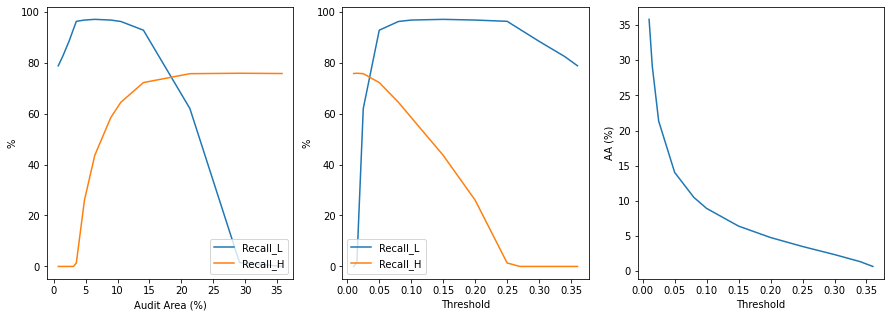

In [132]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['recall_L']*100, label="Recall_L")
ax1.plot(m['AA']*100, m['recall_H']*100, label="Recall_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(np.asarray(threshold_list), m['recall_L']*100, label="Recall_L")
ax2.plot(np.asarray(threshold_list), m['recall_H']*100, label="Recall_H")
ax2.legend(loc="lower left")
ax2.set_ylabel('%')
ax2.set_xlabel('Threshold')

ax3.plot(np.asarray(threshold_list), m['AA']*100, label="AA")
ax3.set_ylabel('AA (%)')
ax3.set_xlabel('Threshold')

if save_figures == True:
    plt.savefig('figures/recall_AA.png', dpi=150, bbox_inches='tight')

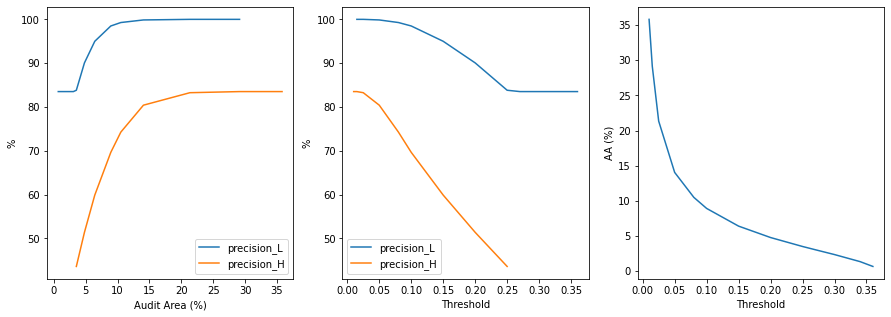

In [133]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['precision_L']*100, label="precision_L")
ax1.plot(m['AA']*100, m['precision_H']*100, label="precision_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(np.asarray(threshold_list), m['precision_L']*100, label="precision_L")
ax2.plot(np.asarray(threshold_list), m['precision_H']*100, label="precision_H")
ax2.legend(loc="lower left")
ax2.set_ylabel('%')
ax2.set_xlabel('Threshold')

ax3.plot(np.asarray(threshold_list), m['AA']*100, label="AA")
ax3.set_ylabel('AA (%)')
ax3.set_xlabel('Threshold')

if save_figures == True:
    plt.savefig('figures/recall_AA.png', dpi=150, bbox_inches='tight')

In [134]:
m['f1_L'] = 2*m['precision_L']*m['recall_L']/(m['precision_L']+m['recall_L'])
m['f1_H'] = 2*m['precision_H']*m['recall_H']/(m['precision_H']+m['recall_H'])

m_audited['f1'] = 2*m_audited['precision']*m_audited['recall']/(m_audited['precision']+m_audited['recall'])

In [135]:

'''
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['f1_L']*100, label="f1_L")
ax1.plot(m['AA']*100, m['f1_H']*100, label="f1_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m['AA']*100, np.asarray(threshold_list), label="AA")
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/f1_AA.png', dpi=150, bbox_inches='tight')
'''

'\nfig, (ax1, ax2) = plt.subplots(1, 2)\nfig.set_figheight(5)\nfig.set_figwidth(15)\nax1.plot(m[\'AA\']*100, m[\'f1_L\']*100, label="f1_L")\nax1.plot(m[\'AA\']*100, m[\'f1_H\']*100, label="f1_H")\nax1.legend(loc="lower right")\nax1.set_ylabel(\'%\')\nax1.set_xlabel(\'Audit Area (%)\')\n\nax2.plot(m[\'AA\']*100, np.asarray(threshold_list), label="AA")\nax2.set_xlabel(\'Audit Area (%)\')\nax2.set_ylabel(\'Threshold\')\n\n# if save_figures == True:\nif True:\n    plt.savefig(\'figures/f1_AA.png\', dpi=150, bbox_inches=\'tight\')\n'

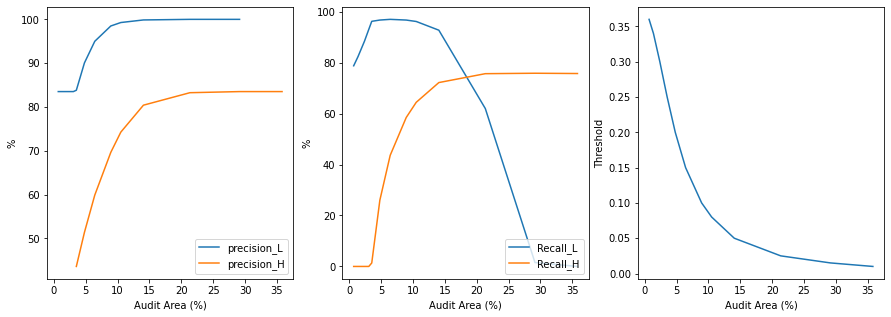

In [136]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['precision_L']*100, label="precision_L")
ax1.plot(m['AA']*100, m['precision_H']*100, label="precision_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m['AA']*100, m['recall_L']*100, label="Recall_L")
ax2.plot(m['AA']*100, m['recall_H']*100, label="Recall_H")
ax2.legend(loc="lower right")
ax2.set_ylabel('%')
ax2.set_xlabel('Audit Area (%)')

ax3.plot(m['AA']*100, np.asarray(threshold_list), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA.png', dpi=150, bbox_inches='tight')

In [137]:
xlim = [-0.3, 12.7]
ylim = [0, 105]


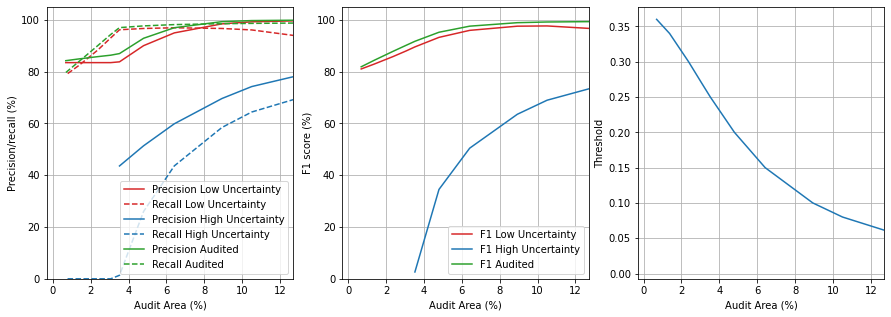

In [138]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['precision_L']*100, 'C3-', label="Precision Low Uncertainty")
ax1.plot(m['AA']*100, m['recall_L']*100, 'C3--', label="Recall Low Uncertainty")
ax1.plot(m['AA']*100, m['precision_H']*100, 'C0-', label="Precision High Uncertainty")
ax1.plot(m['AA']*100, m['recall_H']*100, 'C0--', label="Recall High Uncertainty")
ax1.plot(m['AA']*100, m_audited['precision']*100, 'C2-', label="Precision Audited")
ax1.plot(m['AA']*100, m_audited['recall']*100, 'C2--', label="Recall Audited")

ax1.legend(loc="lower right")
ax1.set_ylabel('Precision/recall (%)')
ax1.set_xlabel('Audit Area (%)')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)
ax1.grid()
ax2.plot(m['AA']*100, m['f1_L']*100, 'C3-', label="F1 Low Uncertainty")
ax2.plot(m['AA']*100, m['f1_H']*100, 'C0-', label="F1 High Uncertainty")
ax2.plot(m['AA']*100, m_audited['f1']*100, 'C2-', label="F1 Audited")

ax2.legend(loc="lower right")
ax2.set_ylabel('F1 score (%)')
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylim(ylim)
ax2.set_xlim(xlim)

ax2.grid()
ax3.plot(m['AA']*100, np.asarray(threshold_list), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')
ax3.grid()
ax3.set_xlim(xlim)

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_f1_AA.png', dpi=150, bbox_inches='tight')

In [139]:


m

{'precision_L': array([       nan, 1.        , 1.        , 0.998648  , 0.99274855,
        0.98488575, 0.94993268, 0.90062509, 0.83816642, 0.83511307,
        0.83511307, 0.83511307, 0.83511307]),
 'recall_L': array([0.        , 0.01529988, 0.6197573 , 0.92724148, 0.96142287,
        0.96703501, 0.96978248, 0.96704489, 0.96206075, 0.93065145,
        0.88358936, 0.82381534, 0.78756274]),
 'recall_Ltotal': array([0.        , 0.00009796, 0.01374206, 0.14375279, 0.33134798,
        0.42726546, 0.57684632, 0.67503651, 0.75056361, 0.75354948,
        0.75354948, 0.75354948, 0.75354948]),
 'AA': array([0.35805801, 0.29136925, 0.21343541, 0.1405203 , 0.10504602,
        0.08933337, 0.06417854, 0.04795909, 0.03524355, 0.03061836,
        0.02375325, 0.01373222, 0.00688361]),
 'precision_H': array([0.83511307, 0.83509517, 0.8325631 , 0.80407286, 0.74257517,
        0.69642927, 0.59882612, 0.51378703, 0.43592677,        nan,
               nan,        nan,        nan]),
 'recall_H': array([0.757

In [140]:
m_audited

{'precision': array([1.        , 1.        , 1.        , 0.9998032 , 0.99755308,
        0.99339017, 0.96996989, 0.92916316, 0.87006497, 0.86383073,
        0.85823521, 0.84935302, 0.84264452]),
 'recall': array([0.99519596, 0.99369519, 0.99156877, 0.98872005, 0.98670465,
        0.98543507, 0.982026  , 0.976996  , 0.97040122, 0.9438484 ,
        0.90072178, 0.83884269, 0.79673749]),
 'f1': array([0.9975922 , 0.99683763, 0.99576654, 0.99423074, 0.99209921,
        0.98939663, 0.97596071, 0.95247943, 0.9174981 , 0.90206856,
        0.87896538, 0.84406514, 0.81904825])}

In [141]:
np.unique(label_mask_val_valid, return_counts=True)

(array([0, 1], dtype=uint8), array([9179787,  270914], dtype=int64))

In [142]:
importlib.reload(_metrics)

threshold_list_val = [0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

loadThresholdMetrics = False
if loadThresholdMetrics == False:
        # threshold_list_val = [0.1]
        # y_test
        ic(y_pred_val.shape, label_mask_val_valid.shape)
        importlib.reload(_metrics)

        metrics_values_val = _metrics.getAA_Recall(y_pred_val, 
                label_mask_val_valid, 
                predicted_val, threshold_list_val)

        ic(metrics_values_val)



ic| y_pred_val.shape: (9450701,)
    label_mask_val_valid.shape: (9450701,)


threshold 0.015
(5505876,) (5505876,)
cm_correct [[5505838       0]
 [     35       3]]
(3944825,) (3944825,)
cm_incorrect [[3625318   48631]
 [  43221  227655]]
[1.         0.07894737 0.00001107 0.41741084 0.82398312 0.84043991]
threshold 0.025
(6669676,) (6669676,)
cm_correct [[6668326       0]
 [     70    1280]]
(2781025,) (2781025,)
cm_incorrect [[2462830   48631]
 [  43186  226378]]
[1.         0.94814815 0.00472475 0.29426653 0.82316579 0.83979315]
threshold 0.05
(7543356,) (7543356,)
cm_correct [[7526029       7]
 [    183   17137]]
(1907345,) (1907345,)
cm_incorrect [[1605127   48624]
 [  43073  210521]]
[0.99959169 0.98943418 0.06325624 0.20182048 0.81236759 0.83014977]
threshold 0.08
(8030030,) (8030030,)
cm_correct [[7953013    3484]
 [    363   73170]]
(1420671,) (1420671,)
cm_incorrect [[1178143   45147]
 [  42893  154488]]
[0.95454901 0.99506344 0.27008571 0.1503244  0.77385228 0.78268932]
threshold 0.1
(8258955,) (8258955,)
cm_correct [[8127319    8511]
 [    511  12261

d:\Jorge\deforestation_uncertainty\src\metrics.py:257: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)


cm_correct [[8873675   48631]
 [  16360  227658]]
(284377,) (284377,)
cm_incorrect [[257481      0]
 [ 26896      0]]
[0.82398503 0.93295577 0.84033309 0.03009057        nan 0.        ]
threshold 0.34
(9289053,) (9289053,)


d:\Jorge\deforestation_uncertainty\src\metrics.py:257: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)


cm_correct [[8985138   48631]
 [  27626  227658]]
(161648,) (161648,)
cm_incorrect [[146018      0]
 [ 15630      0]]
[0.82398503 0.89178327 0.84033309 0.01710434        nan 0.        ]
threshold 0.36
(9370134,) (9370134,)


d:\Jorge\deforestation_uncertainty\src\metrics.py:257: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
d:\Jorge\deforestation_uncertainty\src\metrics.py:257: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| metrics_values_val: array([[1.        , 0.07894737, 0.00001107, 0.41741084, 0.82398312,
                                0.84043991],
                               [1.        , 0.94814815, 0.00472475, 0.29426653, 0.82316579,
                                0.83979315],
                               [0.99959169, 0.98943418, 0.06325624, 0.20182048, 0.81236759,
                                0.83014977],
                               [0.95454901, 0.99506344, 0.27008571, 0.1503244 , 0.77385228,
                                0.78268932],
                               [0.93509247, 0.99584975, 0.45259381, 0.12610133, 0.72362294,
                                0.71077008],
       

cm_correct [[9058394   48631]
 [  35451  227658]]
(80567,) (80567,)
cm_incorrect [[72762     0]
 [ 7805     0]]
[0.82398503 0.86526117 0.84033309 0.00852498        nan 0.        ]


In [143]:
m_val = {'precision_L': metrics_values_val[:,0],
        'recall_L': metrics_values_val[:,1],
        'recall_Ltotal': metrics_values_val[:,2],
        'AA': metrics_values_val[:,3],
        'precision_H': metrics_values_val[:,4],
        'recall_H': metrics_values_val[:,5]}


save_figures=False

In [144]:
threshold_list_val = [0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]


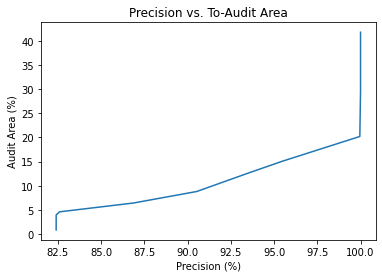

In [145]:
plt.plot(m_val['precision_L']*100, m_val['AA']*100)
plt.title('Precision vs. To-Audit Area')
plt.xlabel('Precision (%)')
plt.ylabel('Audit Area (%)')
if True:
    plt.savefig('figures/precision_AA_val.png', dpi=150, bbox_inches='tight')

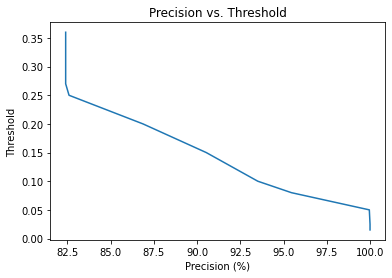

In [146]:
plt.plot(m_val['precision_L']*100, np.asarray(threshold_list_val))
plt.title('Precision vs. Threshold')
plt.xlabel('Precision (%)')
plt.ylabel('Threshold')
if True:
    plt.savefig('figures/precision_total_threshold_val.png', dpi=150, bbox_inches='tight')

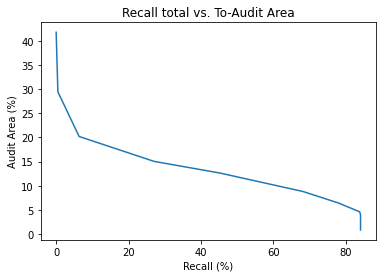

In [147]:
plt.plot(m_val['recall_Ltotal']*100, m_val['AA']*100)
plt.title('Recall total vs. To-Audit Area')
plt.xlabel('Recall (%)')
plt.ylabel('Audit Area (%)')
if True:
    plt.savefig('figures/recall_total_AA_val.png', dpi=150, bbox_inches='tight')

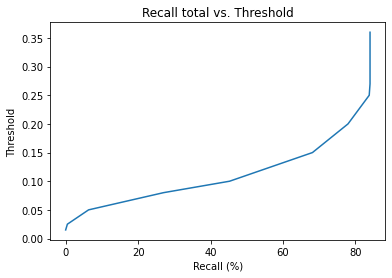

In [148]:
plt.plot(m_val['recall_Ltotal']*100, np.asarray(threshold_list_val))
plt.title('Recall total vs. Threshold')
plt.xlabel('Recall (%)')
plt.ylabel('Threshold')
if True:
    plt.savefig('figures/recall_total_threshold_val.png', dpi=150, bbox_inches='tight')

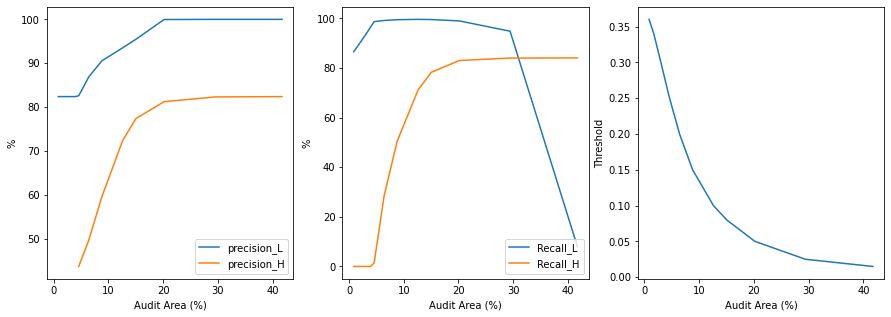

In [149]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['precision_L']*100, label="precision_L")
ax1.plot(m_val['AA']*100, m_val['precision_H']*100, label="precision_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m_val['AA']*100, m_val['recall_L']*100, label="Recall_L")
ax2.plot(m_val['AA']*100, m_val['recall_H']*100, label="Recall_H")
ax2.legend(loc="lower right")
ax2.set_ylabel('%')
ax2.set_xlabel('Audit Area (%)')

ax3.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA_val.png', dpi=150, bbox_inches='tight')

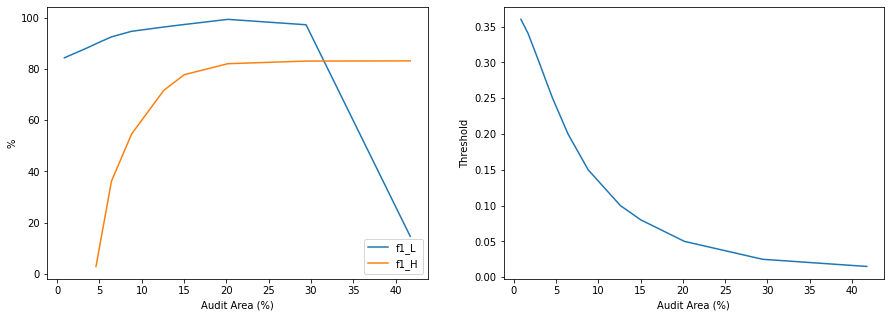

In [150]:
m_val['f1_L'] = 2*m_val['precision_L']*m_val['recall_L']/(m_val['precision_L']+m_val['recall_L'])
m_val['f1_H'] = 2*m_val['precision_H']*m_val['recall_H']/(m_val['precision_H']+m_val['recall_H'])

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['f1_L']*100, label="f1_L")
ax1.plot(m_val['AA']*100, m_val['f1_H']*100, label="f1_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/f1_AA_val.png', dpi=150, bbox_inches='tight')

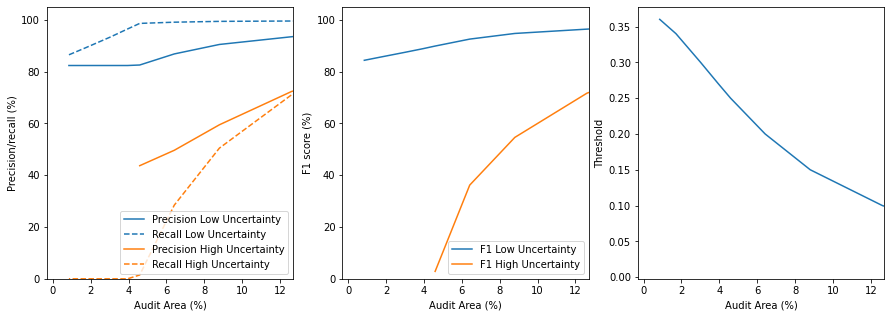

In [151]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['precision_L']*100, 'C0-', label="Precision Low Uncertainty")
ax1.plot(m_val['AA']*100, m_val['recall_L']*100, 'C0--', label="Recall Low Uncertainty")
ax1.plot(m_val['AA']*100, m_val['precision_H']*100, 'C1-', label="Precision High Uncertainty")
ax1.plot(m_val['AA']*100, m_val['recall_H']*100, 'C1--', label="Recall High Uncertainty")
ax1.legend(loc="lower right")
ax1.set_ylabel('Precision/recall (%)')
ax1.set_xlabel('Audit Area (%)')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)

ax2.plot(m_val['AA']*100, m_val['f1_L']*100, label="F1 Low Uncertainty")
ax2.plot(m_val['AA']*100, m_val['f1_H']*100, label="F1 High Uncertainty")
ax2.legend(loc="lower right")
ax2.set_ylabel('F1 score (%)')
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylim(ylim)
ax2.set_xlim(xlim)

ax3.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')
ax3.set_xlim(xlim)

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA_val.png', dpi=150, bbox_inches='tight')